# An Exploration of Bike Share Data in New York City
For my first capstone project, I am going to explore bike share [data provided by Citi Bike](https://www.citibikenyc.com/system-data) in New York City.  For those of you who aren't familiar with bike sharing systems, it is a service often seen in big cities where bikes are available for a fee.  Citi Bike has shared their data from June 2013 to April 2019; their data has been preprocessed to remove trips taken by staff or trips under 60 seconds.  Due to memory limitations, I'm exploring data from 2017-2018, with a 10% sampling rate.  

The data provided is as follows:

| Variable | Explanation   |
|------|------|
|   Trip Duration  | Length of the bike ride in seconds |
|   Starting and ending times and date  | Year:Month:Day  Hour:Minute:Second |
|   Start and end station names and coordinates  | Station name, station ID, latitudes and longitudes |
|   Bike ID  | |
|   Year of birth  | |
|   Gender  | 0 = Unknown, 1 = Male, 2 = Female |
|   User Type  |  Customer = 1 or 3 day pass, Subscriber = annual pass|


There are two main parts I want to explore:
1.  **Time**
    1.  What time of year has more riders?
    2.  When is the most popular time to rent a bike?
2.  **Location**
    1.  Can we identify hotspots?
    2.  Can we prevent bikes from being stolen?

### 1 - Loading the data
Note that despite a 10% sampling rate over 24 months, there are still ~3.3 million rows of data.  

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind

In [9]:
df = pd.read_csv('bikes_10.csv', parse_dates = ['Start Time', 'Stop Time'])

In [10]:
df.shape

(3391298, 15)

In [11]:
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,605,2017-01-04 17:29:06,2017-01-04 17:39:11,341.0,Stanton St & Mangin St,40.717821,-73.976289,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,26424,Subscriber,1973.0,2
1,936,2017-01-21 23:35:23,2017-01-21 23:50:59,466.0,W 25 St & 6 Ave,40.743954,-73.991449,3142.0,1 Ave & E 62 St,40.761227,-73.960940,16944,Subscriber,1973.0,1
2,1324,2017-01-24 22:22:37,2017-01-24 22:44:42,268.0,Howard St & Centre St,40.719105,-73.999733,409.0,DeKalb Ave & Skillman St,40.690649,-73.956431,25176,Subscriber,1983.0,1
3,1133,2017-01-12 08:15:57,2017-01-12 08:34:50,120.0,Lexington Ave & Classon Ave,40.686768,-73.959282,3364.0,Carroll St & 5 Ave,40.675162,-73.981483,25000,Subscriber,1980.0,1
4,1966,2017-01-31 07:34:53,2017-01-31 08:07:40,344.0,Monroe St & Bedford Ave,40.685144,-73.953809,312.0,Allen St & Stanton St,40.722055,-73.989111,18221,Subscriber,1967.0,2


#### 1.1 - Missing Data
For this data visualization project, I will be dropping null values.  Luckily, most of the information aren't null values, with the most missing info coming from the birth year variable.  The number of rows dropped by ~5%.  

In [12]:
df.isnull().sum()/df.shape[0]

Trip Duration              0.000000
Start Time                 0.000000
Stop Time                  0.000000
Start Station ID           0.000073
Start Station Name         0.000073
Start Station Latitude     0.000000
Start Station Longitude    0.000000
End Station ID             0.000073
End Station Name           0.000073
End Station Latitude       0.000000
End Station Longitude      0.000000
Bike ID                    0.000000
User Type                  0.000466
Birth Year                 0.048080
Gender                     0.000000
dtype: float64

In [13]:
df.dropna(axis = 0, inplace = True)

In [14]:
df.shape

(3226420, 15)

### 2 - Time
There are two time variables that we can play with:  start and stop times, indicating when the rider removed the bike from its docking location to the time the bike was re-docked at an ending location.  

**Protip:**  when loading the dataset, parse in date/time variables as datetime datatypes to make it easier to work with the data.  

From the start time and date, I extracted the year, month, day, day of week, hour, and minute into separate columns.  For the end times, I only extracted the hour, minute, and day of week since the majority of rides end within the same day.  The day of week variable is initially a numerical datatype, where Monday is set to 0, Tuesday is set to 1, and Sunday is set to 6.  To avoid confusion, I converted the numbers to the actual name of the day.  In addition, I created a column indicating if a day is a weekend (1) or not (0).  

In [15]:
df_time = pd.DataFrame()

df_time['Start_Year'] = df['Start Time'].dt.year
df_time['Start_Month'] = df['Start Time'].dt.month
df_time['Start_Day'] = df['Start Time'].dt.day
df_time['Start_Dayofweek'] = df['Start Time'].dt.dayofweek
df_time['Start_Hour'] = df['Start Time'].dt.hour
df_time['Start_Minute'] = df['Start Time'].dt.minute

In [16]:
df_time.head()

,Start_Year,Start_Month,Start_Day,Start_Dayofweek,Start_Hour,Start_Minute
0,2017,1,4,2,17,29
1,2017,1,21,5,23,35
2,2017,1,24,1,22,22
3,2017,1,12,3,8,15
4,2017,1,31,1,7,34


In [17]:
dayofweek_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [18]:
df_time['Start_Dayofweek'] = df_time['Start_Dayofweek'].apply(lambda x: dayofweek_dict[x])

In [22]:
def convert_weekend(col):
    '''
    Identifies if the day of week is a weekend (1) or not (0)
    
    Parameters:
    col (str): the day of week
    
    Returns:
    (int): 0 indicates a weekday, 1 indicates a weekend
    
    '''
    if col == 'Sunday' or col == 'Saturday':
        return 1
    else:
        return 0

In [20]:
df_time['Weekend'] = df_time['Start_Dayofweek'].apply(convert_weekend)

In [21]:
df_time.head()

,Start_Year,Start_Month,Start_Day,Start_Dayofweek,Start_Hour,Start_Minute,Weekend
0,2017,1,4,Wednesday,17,29,0
1,2017,1,21,Saturday,23,35,1
2,2017,1,24,Tuesday,22,22,0
3,2017,1,12,Thursday,8,15,0
4,2017,1,31,Tuesday,7,34,0


Lastly, I concatenated my original dataframe with the time dataframe. 

In [23]:
df = pd.concat([df, df_time], axis = 1)

#### 2.1 - What time of year are there more rides?
I define day pass customers as those who have 1 or 3 day passes (aka not annual subscribers).  From a business standpoint, this is important because the company would make most money from drawing in these day pass holders. Below, I've plotted the total number of rides per month based on user type.   

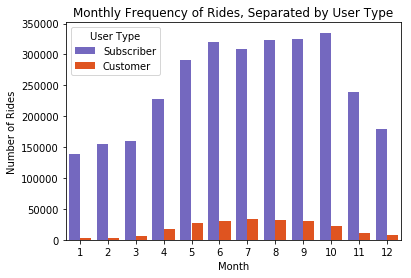

In [24]:
sns.countplot(x = 'Start_Month',  hue = 'User Type', data = df, palette = ['slateblue', 'orangered'])
plt.title('Monthly Frequency of Rides, Separated by User Type')
plt.xlabel('Month')
plt.ylabel('Number of Rides')

Unsurprisingly, **in the cold winter months, the number of rides diminishes drastically, and rises as temperatures warm up.**  What is surprising is how many more annual subscriber rides than there are day pass customers.  

Below, I've generated two graphs that look into the number of rides per month in 2017 vs 2018 separated by user type.  The average number of rides per month for annual subscribers increased by ~10%, whereas the number of rides per month for day pass riders increased by 520% in 2018. Growth from the local residents seems to be stagnating, but with focused advertising, **it might be possible to increase the number of day pass riders for several years.  **

In [28]:
def calc_percent_change(val1, val2):
    '''
    Given two values, calculate the percent change
    
    Parameters:
    val1 (float): the old value
    val2 (float): the new value
    
    Returns:
    (float):  the percent change
    
    '''
    diff = val2 - val1
    return diff/val1 * 100

In [29]:
avg_subscriber_2017 = df[(df['User Type']=='Subscriber') & (df['Start_Year'] ==2017)].shape[0]/12
avg_subscriber_2018 = df[(df['User Type']=='Subscriber') & (df['Start_Year'] ==2018)].shape[0]/12
calc_percent_change(avg_subscriber_2017, avg_subscriber_2018)

8.350830529732962

In [30]:
avg_customer_2017 = df[(df['User Type']=='Customer') & (df['Start_Year'] ==2017)].shape[0]/12
avg_customer_2018 = df[(df['User Type']=='Customer') & (df['Start_Year'] ==2018)].shape[0]/12
calc_percent_change(avg_customer_2017, avg_customer_2018)

521.8188827138681

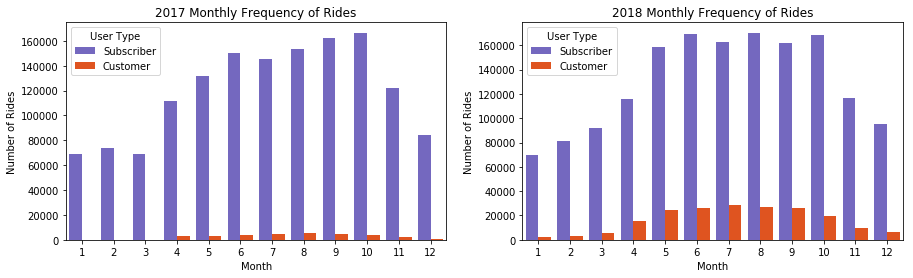

In [31]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.countplot(x = 'Start_Month',  hue = 'User Type', data = df[df['Start_Year']==2017], palette = ['slateblue', 'orangered'],
             ax = axis1)
sns.countplot(x = 'Start_Month',  hue = 'User Type', data = df[df['Start_Year']==2018], palette = ['slateblue', 'orangered'],
             ax = axis2)

axis1.set_title('2017 Monthly Frequency of Rides')
axis2.set_title('2018 Monthly Frequency of Rides')

for axis in [axis1, axis2]:
    axis.set_xlabel('Month')
    axis.set_ylabel('Number of Rides')

#### 2.2 - When is the most popular time to rent a bike?


##### 2.2.1 - Most Popular Day?
There are several ways to think about 'most popular time'.  One way is to look at the number of rides per day, as seen below.  I have clearly overestimated the popularity of the NYC subway system, as I thought the most number of rides would be on the weekends due to tourism.  Instead, the weekend ended up having the least number of rides, and the day of week with the most rides was on Wednesday.  

In [32]:
weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

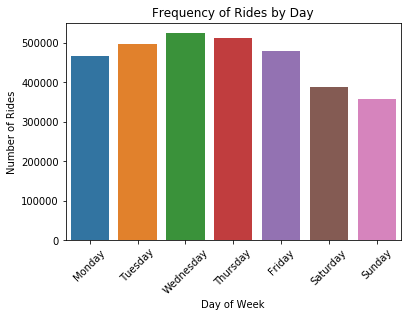

In [33]:
sns.countplot(x = 'Start_Dayofweek', order = weekday_lst, data = df_time)
plt.xticks(rotation = 45)
plt.title('Frequency of Rides by Day')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')

However, splitting number of daily rides by user type might reveal why the weekend has less overall rides. It seems that those who have annual membership ride during the weekdays, and the average number of such riders decreases by ~30% on the weekend. Meanwhile, the average number of rides who have a day pass increased by a whopping 100% on weekends compared to weekdays.  

**This seems to indicate that NYC locals are more likely rent bikes during the weekday whereas on weekends, tourists are more likely to rent bikes.  **

In [34]:
avg_subscriber_weekday = df[(df['User Type']=='Subscriber') & (df['Weekend'] == 0)].shape[0]/5
avg_subscriber_weekend = df[(df['User Type']=='Subscriber') & (df['Weekend'] == 1)].shape[0]/2
calc_percent_change(avg_subscriber_weekday, avg_subscriber_weekend)

-31.47741380956929

In [35]:
avg_customer_weekday = df[(df['User Type']=='Customer') & (df['Weekend'] == 0)].shape[0]/5
avg_customer_weekend = df[(df['User Type']=='Customer') & (df['Weekend'] == 1)].shape[0]/2
calc_percent_change(avg_customer_weekday, avg_customer_weekend)

101.73541025001809

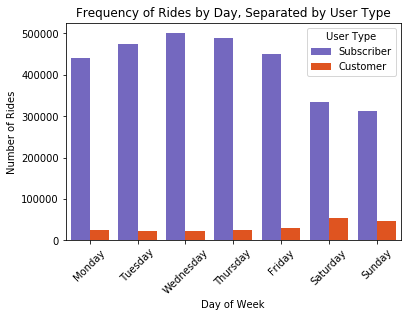

In [36]:
sns.countplot(x = 'Start_Dayofweek', hue = 'User Type', order = weekday_lst, data = df, palette= ['slateblue', 'orangered'])

plt.title('Frequency of Rides by Day, Separated by User Type')
plt.xticks(rotation = 45)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')

##### 2.2.2 - Most  Popular Hour?

The other way to look at the most popular time to rent a bike is by hour.  Below is a histogram of when riders started their bike ride broken down by hour of the day (military time).  Unsurprisingly, there are relatively few riders between midnight and ~6am.  The histogram shows a bimodal model, with peaks at ~8am and ~5pm.  My guess is that the annual subscribers are dominating the plot by riding to and from work.  

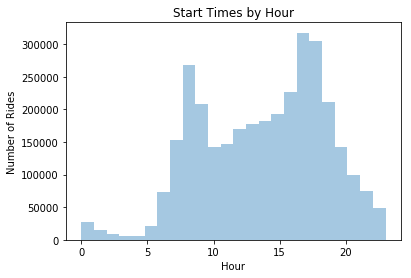

In [37]:
sns.distplot(a = df['Start_Hour'], kde = False, bins = 24)
plt.title('Start Times by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')

To confirm if it is annual subscribers going to and from work, I've graphed a normalized distribution of rides based on start hour, separated by weekend or weekday.  

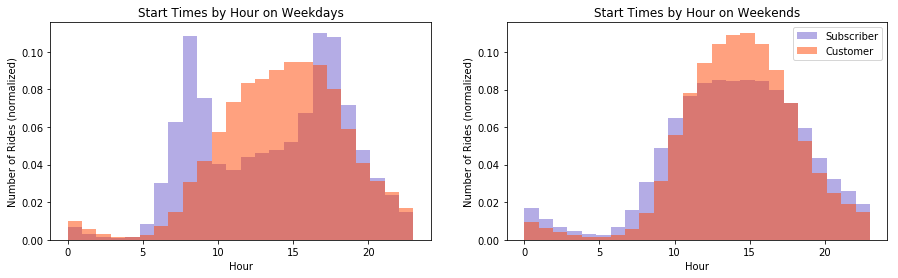

In [38]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.distplot(a = df[(df['User Type']=='Subscriber') & (df['Weekend'] == 0)]['Start_Hour'], kde = False, norm_hist = True, 
             bins = 24, color = 'slateblue', label = 'Subscriber', hist_kws={"alpha": 0.5}, ax = axis1)
sns.distplot(a = df[(df['User Type']=='Customer') & (df['Weekend'] == 0)]['Start_Hour'], kde = False, norm_hist = True, 
             bins = 24, color = 'orangered', label = 'Customer', hist_kws={"alpha": 0.5}, ax = axis1)

sns.distplot(a = df[(df['User Type']=='Subscriber') & (df['Weekend'] == 1)]['Start_Hour'], kde = False, norm_hist = True,
             bins = 24, color = 'slateblue', hist_kws={"alpha": 0.5}, ax = axis2)
sns.distplot(a = df[(df['User Type']=='Customer') & (df['Weekend'] == 1)]['Start_Hour'], kde = False, norm_hist = True,
             bins = 24, color = 'orangered', hist_kws={"alpha": 0.5}, ax = axis2)

plt.legend(['Subscriber', 'Customer'])

axis1.set_title('Start Times by Hour on Weekdays')
axis2.set_title('Start Times by Hour on Weekends')

for axis in [axis1, axis2]:
    axis.set_xlabel('Hour')
    axis.set_ylabel('Number of Rides (normalized)')

As suspected, **the peaks at 8am and 5pm are dominated by the annual subscribers on the weekdays.  On the weekend, annual subscribers and day pass holders have similar schedules.**  For now, I think its safe to say that annual subscribers are most likely NYC locals, and day pass customers are tourists.  

### 3 - Location
Using location data to elucidate trends is useful for the company to create a plan to reach a broader audience as well as keep operations running smoothly.  

##### 3.1.1 - Can we Locate Hotspots?
By hotspots, I mean can we identify zones/areas in NYC that are tourist centric or where the locals tend to be?  To figure that out, first I plotted the latitudes and longitudes in a scatterplot.  

In [39]:
def create_station_df(tmp_df):
    '''
    Returns a dataframe of station names and the station's longitude and latitude
    
    Parameters:
    tmp_df (pandas df): a dataframe of station names
    
    Returns:
    station_df (pandas df):  a dataframe with 3 columns:  station name, station latitude, and station longitude
    
    '''
    station_lat, station_long, station_name = [], [], []
    
    for station in tmp_df:
        station_name.append(station)
        station_lat.append(df[df['Start Station Name'] == station]['Start Station Latitude'].unique()[0])
        station_long.append(df[df['Start Station Name'] == station]['Start Station Longitude'].unique()[0])
        
    station_df = pd.DataFrame()
    station_df['Latitude'] = station_lat
    station_df['Longitude'] = station_long
    station_df['Station Name'] = station_name
    
    return station_df

In [40]:
master_station_df = create_station_df(df['Start Station Name'].unique())

Due to the density of stations, we can see geographic features in the scatterplot, namely the East River flowing in the middle, and Central Park is the blank space near the top.  The edges above Central Park (and heads to the lower left corner) is the Hudson River that separates New York and New Jersey.  Meanwhile, south of the East river, only parts of the Brooklyn is populated with bike stations.

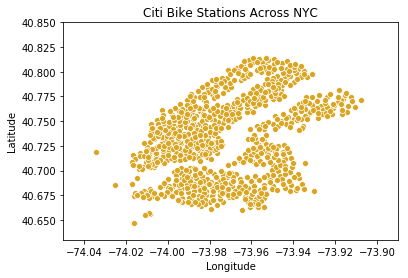

In [41]:
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = master_station_df, color = 'goldenrod')

plt.ylim([40.63, 40.85])
plt.xlim([-74.05,-73.89])

plt.title('Citi Bike Stations Across NYC')

In order to map out any potential zones, below I've identified the top 25 most popular start stations for both annual subscribers (left) and day pass customers (right). For annual subscribers, Pershing Square North is by far the most popular station, but stations along Broadway and 8th Ave are quite popular as well.  For day pass customers, without a doubt Central Park is the most popular area, although Pershing Square North also makes the list.  

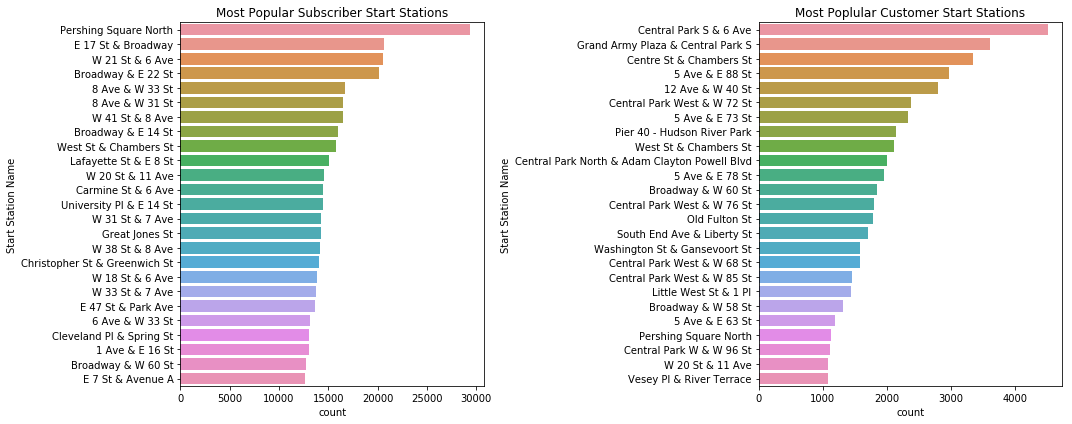

In [31]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,6))

sns.countplot(y = 'Start Station Name', order = df[df['User Type']=='Subscriber']['Start Station Name'].value_counts().index[:25], 
              data = df[df['User Type']=='Subscriber'], ax = axis1)
sns.countplot(y = 'Start Station Name', order = df[df['User Type']=='Customer']['Start Station Name'].value_counts().index[:25], 
              data = df[df['User Type']=='Customer'], ax = axis2)

axis1.set_title('Most Popular Subscriber Start Stations')
axis2.set_title('Most Poplular Customer Start Stations')

plt.tight_layout()

In [32]:
customer_station_df = create_station_df(df[df['User Type']=='Customer']['Start Station Name'].value_counts().index[:25])

In [33]:
subscriber_station_df = create_station_df(df[df['User Type']=='Subscriber']['Start Station Name'].value_counts().index[:25])

In [34]:
len(set(subscriber_station_df['Station Name'].values).intersection(customer_station_df['Station Name']))

4

Below is the same scatterplot as above, but I've plotted the most popular stations for annual subscribers (blue) and day pass customers (red).  Not surprisingly, **the day pass customers really enjoy visiting Central Park.  In addition to Central Park however, they also enjoy visiting the western shoreline.  Annual subscribers however, are centered around midtown Manhattan**

Its also curious that all the hotspots are are north of the East river.  Could there be potential for growth south of the river?

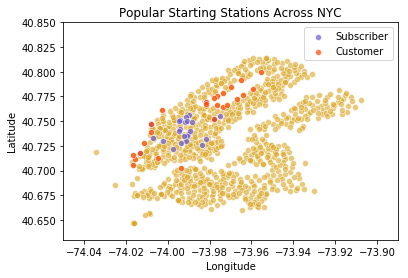

In [35]:
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = master_station_df, color = 'goldenrod', alpha = 0.6)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = subscriber_station_df, color = 'slateblue', 
                alpha= 0.7, label = 'Subscriber')
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = customer_station_df, color = 'orangered', 
                alpha = 0.7, label = 'Customer')

plt.ylim([40.63, 40.85])
plt.xlim([-74.05,-73.89])
plt.legend()

plt.title('Popular Starting Stations Across NYC')

#### 3.2 - Can we Prevent Bikes from Being Stolen?
Lastly, I would like to see if we can identify trends from stolen bikes from this dataset.  From the data given, I think one of the strongest indicators is the length of the bike ride.  This is mainly because of how pricing works.  For annual subscribers, the first 45 minutes are free whereas for day pass users, the first 30 minutes are free.  For every 15 minutes after that, an extra charge is incurred.  Thus, I can't see the majority of riders riding for more than an hour, if that. 

Thus, the first step to figuring out which bikes are stolen is to analyze the duration of the ride.  The data is given in seconds though, which is difficult to interpret.  I'll change it to minutes.  

In [42]:
df['Trip Duration'] = df['Trip Duration'].apply(lambda x: x/60)

##### 3.2.1 - Length of the Bike Ride

Below, I've created histograms and boxplot for what I've deemed as "short trips", or trip durations under 60 minutes.  The histogram shows that the majority of rides are for about ten minutes, with the number of rides quickly dropping as the time duration approaches 60 minutes.  The boxplot on the right looks at the range of trip durations based on user type.  Here, it shows that annual subscribers have shorter rides (median ~9 min)  whereas day pass customers take fuller advantage of their free 30 minutes (median ~20 min).   

In [43]:
df[(df['User Type'] == 'Subscriber') & (df['Trip Duration'] < 60)]['Trip Duration'].median()

9.383333333333333

In [44]:
df[(df['User Type'] == 'Customer') & (df['Trip Duration'] < 60)]['Trip Duration'].median()

20.316666666666666

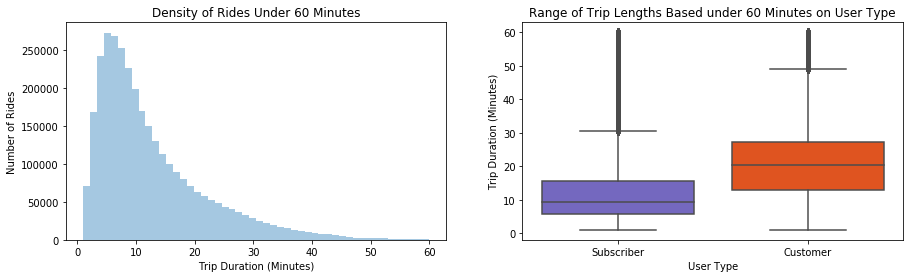

In [40]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.distplot(a = df[df['Trip Duration'] < 60]['Trip Duration'], kde = False, ax = axis1)
sns.boxplot(x = 'User Type', y = 'Trip Duration', data = df[df['Trip Duration'] < 60], palette = ['slateblue', 'orangered'])

axis1.set_title('Density of Rides Under 60 Minutes')
axis1.set_xlabel('Trip Duration (Minutes)')
axis1.set_ylabel('Number of Rides')

axis2.set_title('Range of Trip Lengths Based under 60 Minutes on User Type')
axis2.set_ylabel('Trip Duration (Minutes)')


There are a few reasons why a bike could be out for more than an hour, such as the rider was actually riding for more than an hour, or the rider didn't dock the bike correctly.  In the case that the bike didn't get docked correctly, I'll give the rider an 8 hour/480 minute buffer in case they come back to re-dock their bicycle.  

Thus, I am assuming bikes that are out for 8 hours or more are stolen.  For visual purposes, below I've plotted a boxplot for trip durations between 480 and 7000 minutes, although future analysis for "long trips" will be for trip durations for more than 480 minutes.  For reference, 480 and 7000 minutes corresponds to 8 hours and ~5 days respectively.  For this plot, the median trip duration for an annual subscriber is ~900 minutes whereas for a day pass customer, it is ~1200 minutes.  However, for the full range of a long trip, the median for a subscriber is ~1000 minutes and ~1500 minutes for a customer.

In [57]:
df[(df['User Type'] == 'Subscriber') & (df['Trip Duration'] > 480)]['Trip Duration'].median()

987.3666666666667

In [58]:
df[(df['User Type'] == 'Customer') & (df['Trip Duration'] > 480)]['Trip Duration'].median()

1524.9583333333335

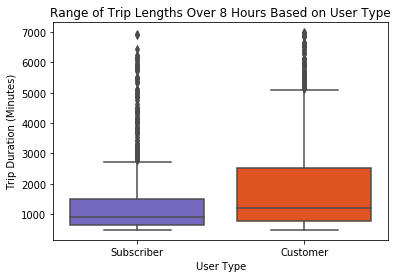

In [43]:
sns.boxplot(x = 'User Type', y = 'Trip Duration', 
            data = df[(df['Trip Duration'] > 480) & (df['Trip Duration'] < 7000)], palette = ['slateblue', 'orangered'])

plt.title('Range of Trip Lengths Over 8 Hours Based on User Type')
plt.ylabel('Trip Duration (Minutes)')

##### 3.2.2 - Suspicious Stations
Curiously, 10% of the bikes returned from long trips end up at one of three places:  the NYCBS Depot - Gow, the NYCBS Depot - Delancey, and at Fulton St & Utica Ave.  10% doesn't sound like a lot, but its a good starting point.  Googling and asking a NYC resident didn't have any results, but my best guess on what NYCBS stands for is New York City Bus Station Depot.  Bus depots...stolen bikes...suspicious isn't it?

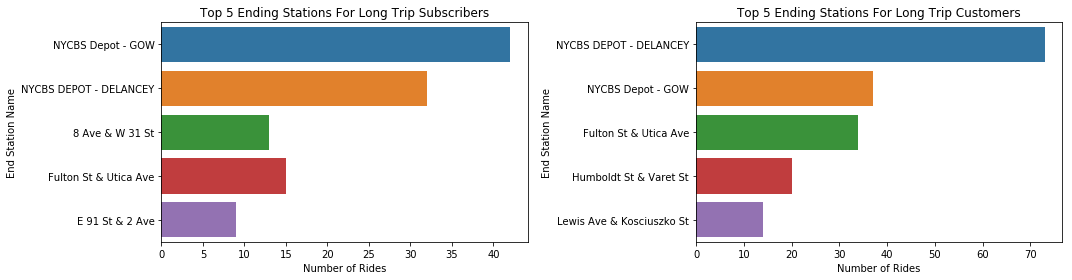

In [44]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

sns.countplot(y = 'End Station Name', 
              order = df[(df['Trip Duration'] > 480) & (df['User Type'] == 'Subscriber')]['End Station Name'].value_counts().index[:5],
            data = df[(df['Trip Duration'] > 200) & (df['User Type'] == 'Subscriber')], ax = axis1)

sns.countplot(y = 'End Station Name', 
              order = df[(df['Trip Duration'] > 480) & (df['User Type'] == 'Customer')]['End Station Name'].value_counts().index[:5],
            data = df[(df['Trip Duration'] > 200) & (df['User Type'] == 'Customer')], ax = axis2)

axis1.set_title('Top 5 Ending Stations For Long Trip Subscribers')
axis2.set_title('Top 5 Ending Stations For Long Trip Customers')

plt.xlabel('Number of Rides')

for ax in [axis1, axis2]:
    ax.set_xlabel('Number of Rides')

plt.tight_layout()

In [45]:
stolen_station_df = create_station_df(df[(df['Trip Duration'] > 1500)]['End Station Name'].value_counts().index[:3])

In [46]:
gowlong_station_df = create_station_df(df[(df['End Station Name'] == 'NYCBS Depot - GOW') 
                                      & (df['Trip Duration'] > 480)]['Start Station Name'].value_counts().index[:13])

In [47]:
delanceylong_station_df = create_station_df(df[(df['End Station Name'] == 'NYCBS DEPOT - DELANCEY') 
                                           & (df['Trip Duration'] > 480)]['Start Station Name'].value_counts().index[:13])

In [48]:
fultonlong_station_df = create_station_df(df[(df['End Station Name'] == 'Fulton St & Utica Ave') & (df['Trip Duration'] > 480)]['Start Station Name'].value_counts().index[:5])

In [49]:
gowshort_station_df= create_station_df(df[(df['End Station Name'] == 'NYCBS Depot - GOW') 
                            & (df['Trip Duration'] < 60)]['Start Station Name'].value_counts().index[:5]) 

In [50]:
delanceyshort_station_df = create_station_df(df[(df['End Station Name'] == 'NYCBS DEPOT - DELANCEY') 
                            & (df['Trip Duration'] < 60)]['Start Station Name'].value_counts().index[:5]) 

In [51]:
fultonshort_station_df = create_station_df(df[(df['End Station Name'] == 'Fulton St & Utica Ave') 
                            & (df['Trip Duration'] < 60)]['Start Station Name'].value_counts().index[:5]) 

I focused on these three ending stations, which I will call Gow, Delancey, and Fulton, and looked at the top starting stations for short and long rides.  

Below on the top left, I've plotted the location of the three ending stations to make it easier to see the distance between ending and starting stations. 

On the bottom left, I've plotted the top starting stations for short rides that ended up in one of the three suspicious stations.  For the most part, they start near their respective ending stations, although those ending up at the Delancey station had some bridge crossings.  

On the bottom right are the top starting stations for long rides that ended up in one of the three suspicious stations.  And for each individual ending station, there doesn't seem to be a pattern where the starting station is.  **There does seem to be a cluster of stolen bikes in the lower right corner of the map however (coordinates -73.93, 40.68), suggesting that security should be increased in that area if possible.  **

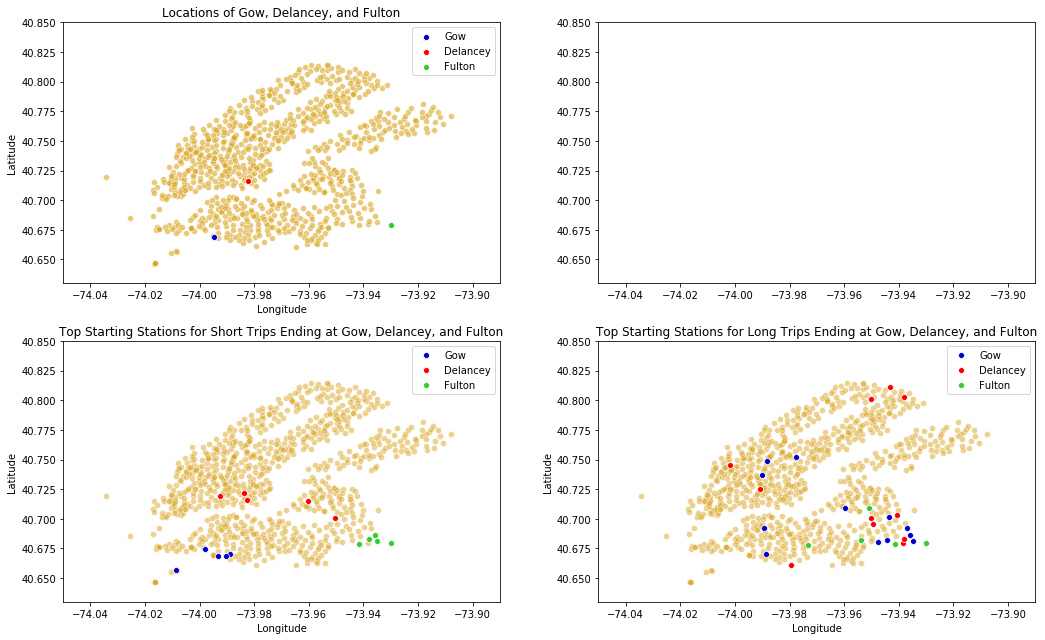

In [52]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(15,9))
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = master_station_df, color = 'goldenrod', alpha = 0.6, ax = axis1)
sns.scatterplot(y = 'Latitude', x = 'Longitude', 
                data = stolen_station_df[stolen_station_df['Station Name'] == 'NYCBS Depot - GOW'], 
                color = 'mediumblue', label = 'Gow', ax = axis1)
sns.scatterplot(y = 'Latitude', x = 'Longitude', 
                data = stolen_station_df[stolen_station_df['Station Name'] == 'NYCBS DEPOT - DELANCEY'], 
                color = 'red', label = 'Delancey', ax = axis1)
sns.scatterplot(y = 'Latitude', x = 'Longitude', 
                data = stolen_station_df[stolen_station_df['Station Name'] == 'Fulton St & Utica Ave'], 
                color = 'limegreen', label = 'Fulton', ax = axis1)

sns.scatterplot(y = 'Latitude', x = 'Longitude', data = master_station_df, color = 'goldenrod', alpha = 0.5, ax = axis3)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = gowshort_station_df, color = 'mediumblue', label = 'Gow', ax = axis3)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = delanceyshort_station_df, color = 'red', label = 'Delancey', ax = axis3)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = fultonshort_station_df, color = 'limegreen', label = 'Fulton', ax = axis3)

sns.scatterplot(y = 'Latitude', x = 'Longitude', data = master_station_df, color = 'goldenrod', alpha = 0.5, ax = axis4)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = gowlong_station_df, color = 'mediumblue', label = 'Gow', ax = axis4)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = delanceylong_station_df, color = 'red', label = 'Delancey', ax = axis4)
sns.scatterplot(y = 'Latitude', x = 'Longitude', data = fultonlong_station_df, color = 'limegreen', label = 'Fulton', ax = axis4)


axis1.set_title('Locations of Gow, Delancey, and Fulton')
axis3.set_title('Top Starting Stations for Short Trips Ending at Gow, Delancey, and Fulton')
axis4.set_title('Top Starting Stations for Long Trips Ending at Gow, Delancey, and Fulton')

for ax in [axis1, axis2, axis3, axis4]:
    ax.set_ylim([40.63, 40.85])
    ax.set_xlim([-74.05,-73.89])

plt.legend()
plt.tight_layout()

Lastly, while I'm fairly certain that the long rides that ended up at bus stations Gow and Delancey were stolen, I'm not sure about those that ended up at Fulton.  Thus, I used t-tests to compare the trip durations for Gow, Delancey, and Fulton.  Since most of the long rides ended up at Delancey, I'm going to assume that the mean trip duration of bikes that ended up at Delancey are stolen.  The null hypothesis is that the bicycles that ended up at the two stations have similar mean trip durations.  The null hypothesis is rejected if the significance (p-value) is less than 0.05, so the bicycles that end up at the two stations do not have similar mean trip durations.  Results are summarized and discussed below:



| Population 1 | Population 2   | t-statistic   | p-value   |
|------|------|
|   Delancey  | Gow |  0.191 |  0.849 |
|   Delancey  | Fulton |  2.44 |  0.0178  |
|   Gow  | Fulton |  2.19 |  0.033  |

1.  Delancey vs Gow:  The t-statistic is pretty small, which makes me suspect the mean trip durations between Gow and Delancey are similar.  The p-value is over 0.05, so we cannot reject the null hypothesis.  Thus, the mean long trip duration between Gow and Delancey are similar, and since I assumed the bikes at Delancey were stolen, I can say that the bikes at Gow were also stolen.  
2.  Delancey  vs Fulton:  The t-statistic is a little bigger than Delancey vs Gow, but not too much bigger.  The p-value however, is lower than 0.05, so we reject the null hypothesis, and say that the bikes at Fulton were not stolen.  
3.  Gow vs Fulton:  By now, we can guess that Gow vs Fulton should not have similar means, but this is just a sanity check.  Indeed, the p-value is less than 0.05, so this is in line with the first two t-tests, that the bikes at Gow were stolen and the bikes at Fulton were not.  

In [53]:
np.random.seed(seed=365)

gow_sample = np.random.choice(df[(df['End Station Name'] == 'NYCBS Depot - GOW') & (df['Trip Duration'] > 480)]['Trip Duration'],
                              size = 38, replace = False)
delancey_sample = np.random.choice(df[(df['End Station Name'] == 'NYCBS DEPOT - DELANCEY') & (df['Trip Duration'] > 480)]['Trip Duration'], 
                                   size = 50, replace = False)
fulton_sample = np.random.choice(df[(df['End Station Name'] == 'Fulton St & Utica Ave') & (df['Trip Duration'] > 480)]['Trip Duration'], 
                                             size = 15, replace = False)

In [54]:
print('Gow mean: {}'.format(gow_sample.mean()))
print('Gow std: {}\n'.format(gow_sample.std()))
print('Delancey mean: {}'.format(delancey_sample.mean()))
print('Delancey std: {}\n'.format(delancey_sample.std()))
print('Fulton mean: {}'.format(fulton_sample.mean()))
print('Fulton std: {}\n'.format(fulton_sample.std()))

print('Gow-Delancey t-test: {}'.format(ttest_ind(gow_sample, delancey_sample, equal_var=False)))
print('Delancey-Fulton t-test: {}'.format(ttest_ind(delancey_sample, fulton_sample, equal_var=False)))
print('Gow-Fulton t-test: {}'.format(ttest_ind(gow_sample, fulton_sample, equal_var=False)))


Gow mean: 15599.833333333336
Gow std: 20840.196952979164

Delancey mean: 14782.629
Delancey std: 17865.155554473386

Fulton mean: 7006.467777777778
Fulton std: 7131.42927045475

Gow-Delancey t-test: Ttest_indResult(statistic=0.19128385433859932, pvalue=0.84883730822859593)
Delancey-Fulton t-test: Ttest_indResult(statistic=2.4412560878392484, pvalue=0.017768774299059029)
Gow-Fulton t-test: Ttest_indResult(statistic=2.1918660165875372, pvalue=0.03301420628519712)


There were some big assumptions concerning the stolen bikes and trip durations.  Perhaps a better metric would have been to compare distance of the start and end stations, although when I tested that elsewhere, and the time duration vs distance had a generally positive trend.  An even better metric would have been to see odometer readings for each bike, as that could tell us if the bike was incorrectly docked or taken out for an illicit joyride.  In either case, we don't have maintenance data to confirm if these bikes were stolen.  

Another thing to consider is that these are the stolen bikes that were actually returned. There is no data (that I know of) detailing how many bikes that weren't returned, so their starting stations could be in a completely different location.  

### 4 - Conclusion
With this Citi Bike Data from the time period of January 1, 2017 to December 31, 2018, I explored two subcategories, time and location, to elucidate trends.  For the time subcategory, I discovered that the most popular time to rent a bike during the year was during the summer months (June to Sept).  When looking at trends between 2017 and 2018, I discovered that the number of day pass rides skyrocketed by 520% in 2018, indicating a potential market to capitalize on.  In addition, on weekdays it seems that those with annual subscriptions rent a bike at 8am and 5pm, whereas day pass customers start renting bikes at around 8am, and the number of rides increases until it peaks at 3pm.  This leads me to believe that annual subscribers are locals and day pass customers are tourists.  On weekdays, annual subscribers and day pass customers have similar schedules, starting out at 8am and peaking at 3pm.  Knowing the schedules of the riders could help the company figure out when is a good time to move bikes around so that stations aren't overflowing or empty.

For location, the first thing I explored was to try and identify hotspots, or areas where a certain demographic congregates to. I found that the day pass customers tend to cluster around Central Park and parts of the coastline, whereas the annual subscribers tend to cluster around midtown Manhattan.  South of the East River, there were no clusters, which again, is an untapped market.  I also tried to identify stolen bikes and where they are stolen from.  I assumed that bikes that were rented out for more than 8 hours were stolen bikes, and found that about 10% of them were returned to 3 stations.  The stations these bikes were stolen from were from all over the city, but there was a cluster of stations in Brooklyn that many of the stolen bikes came from.  It is advisable to increase security, light the stations well, and/or warn customers to double check their bikes are correctly docked when returning bikes in this area.  

### 5 - Further Research
An interesting problem for further research would be to **track the flux of bikes in and out of stations** so the company can prevent each station from becoming overcrowded or too empty.  The first step is to figure out which stations are consistently over or under populated.  This might be by plotting the most popular stops, but will most likely be more involved, tracking bike flux by hour, day of week, season, or what area it is (ex: residential, business, touristy, etc.).  In addition, special consideration will have to be given for holidays, parades, and special events.  

The second step would be to figure out at what time to move bikes from overfilled stations to emptier ones.  Will any stations hit 0 bikes during the rush hours?  Or will supplies last until after rush hour, so drivers can avoid traffic?  A third, or perhaps parallel step, would be to figure out which overfilled stations should have bikes transferred to emptier stations.  A primitive way would be to use a distance formula.  The smarter (and more complicated) way is out of the scope of this dataset and would involve traffic algorithms to account for one way streets, rush hour, and nearby parking/loading zones.  
